# **Natural Langage Processing project : Clustering Amazon customers reviews**

The aim of this collab notebook will be to cluster some customers reviews about products on Amazon (The dataset can be found on [kaggle](https://www.kaggle.com/bittlingmayer/amazonreviews)). To this purpose, we will adapt the code we used during the NLP workshop on march 2nd and march 3rd. We will also use notions from other courses we had this year (Supervised/Unsupervised learning).


First, we intall all packages usefulfor the analysis

In [ ]:
!pip install umap-learn -q
!pip install -q hdbscan
!pip install tqdm
!pip install --upgrade gensim -q
!pip install -q annoy
!pip install mglearn

     |████████████████████████████████| 86 kB 3.2 MB/s 
     |████████████████████████████████| 1.1 MB 11.6 MB/s 
     |████████████████████████████████| 5.2 MB 5.6 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 24.1 MB 40.5 MB/s 
     |████████████████████████████████| 646 kB 5.3 MB/s 
     |████████████████████████████████| 540 kB 5.3 MB/s 
  Created wheel for mglearn: filename=mglearn-0.1.9-py2.py3-none-any.whl size=582639 sha256=4b90ac6e816f1e10b0718e8f9cce373a66fece30663477422797417f84b9307a
  Stored in directory: /root/.cache/pip/wheels/f1/17/e1/1720d6dcd70187b6b6c3750cb3508798f2b1d57c9d3214b08b
Successfully built mglearn


Then, we import all packages and initialize spacy to work with english text data.

In [ ]:
import pandas as pd
import numpy as np
import spacy
import tqdm

nlp = spacy.load('en')

We import and clean our dataset containig Amazon reviews

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/test.ft.txt', delimiter = "\t", header = None)

df['output'] = df[0].apply(lambda x : x[:10])

df['data'] = df[0].apply(lambda x : x[10:])

df = df.dropna(how='any',axis=0) 

df = df.sample(n=60000, random_state=1)

df = df.reset_index()


In [ ]:
df.drop(df.columns[[0,1, 2]], axis=1, inplace=True)


Here is an example of how looks a review

In [ ]:
nlp(df['data'][0])

 Best Movie I've Seen in Years!: Okay, it was expensive to see Pirates of the Caribbean THREE TIMES, but it was worth it. Not too scary, if you have little ones to think of, but thrilling for even the most experienced of viewers. Trust me. No matter how old, or young, you are, you will LOVE this movie!

We clean the data to lower the text and seperate the words

In [ ]:
%%time
clean_text = []


pbar = tqdm.tqdm(total=len(df['data']),position=0, leave=True)

for text in nlp.pipe(df['data'], disable=["tagger", "parser", "ner"]):

  txt = [token.lemma_.lower() for token in text 
         if token.is_alpha 
         and not token.is_stop 
         and not token.is_punct]

  clean_text.append(txt)

  pbar.update(1)

100%|█████████▉| 59856/60000 [00:56<00:00, 1405.86it/s]

CPU times: user 50.7 s, sys: 835 ms, total: 51.6 s
Wall time: 57.1 s


In [ ]:
df['clean_text'] = clean_text

In [ ]:
df['clean_text'].isnull().sum()

0

We import all packages to use Word2Vec

In [ ]:
from gensim.models import Word2Vec
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
from sklearn.metrics.pairwise import cosine_similarity

Basically, the Word2Vec embedding captures the semantic properties of a word. It also allows to reduce the dimension of the problem and make the learning task easier.

Here, we are training the model

In [ ]:
w2v_model = Word2Vec(sentences=df['clean_text'], vector_size=300, window=5, min_count=2, workers=2, epochs=5)

2022-03-13 19:04:16,359 : INFO : collecting all words and their counts
2022-03-13 19:04:16,361 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2022-03-13 19:04:16,451 : INFO : PROGRESS: at sentence #10000, processed 340352 words, keeping 27805 word types
2022-03-13 19:04:16,540 : INFO : PROGRESS: at sentence #20000, processed 677779 words, keeping 40715 word types
2022-03-13 19:04:16,627 : INFO : PROGRESS: at sentence #30000, processed 1018312 words, keeping 50798 word types
2022-03-13 19:04:16,730 : INFO : PROGRESS: at sentence #40000, processed 1361640 words, keeping 59773 word types
2022-03-13 19:04:16,824 : INFO : PROGRESS: at sentence #50000, processed 1701159 words, keeping 67906 word types
2022-03-13 19:04:16,911 : INFO : collected 75241 word types from a corpus of 2039649 raw words and 60000 sentences
2022-03-13 19:04:16,917 : INFO : Creating a fresh vocabulary
2022-03-13 19:04:17,105 : INFO : Word2Vec lifecycle event {'msg': 'effective_min_count=2 re

Thanks to the model, we can now finding all similars words to one of the word contained in our dataset. The more the cosign similarity between two words is close to 1, the more these word are close in the sub vector space. 

In [ ]:
w2v_model.wv.similar_by_word('music')

[('listener', 0.7874345183372498),
 ('singe', 0.7695167660713196),
 ('tune', 0.7672346234321594),
 ('instrument', 0.7402727007865906),
 ('listen', 0.7329652905464172),
 ('artist', 0.7313811779022217),
 ('jazz', 0.7209311723709106),
 ('dance', 0.7200528383255005),
 ('song', 0.7197884917259216),
 ('piano', 0.7184898257255554)]

So, the word 'music' is close to the words 'listener', 'tune', 'singe',... (They are really similar). 


In [ ]:
song = w2v_model.wv['song'].reshape(1,300)
music = w2v_model.wv['music'].reshape(1,300)

But we can also calculate the similarity between two words.

In [ ]:
cosine_similarity(song, music)

array([[0.7197885]], dtype=float32)

Music and Song are very similar words.

Now, we will use Tfidf

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

We use the same trick as during the workshop to use Tfidf on already tokenized text.

In [ ]:
## Useless function (do nothing)

def dummy_fun(doc):
    return doc

In [ ]:
# we use our previous embeddings

tfidf = TfidfVectorizer(vocabulary=w2v_model.wv.key_to_index.keys(),
    tokenizer=dummy_fun,
    preprocessor=dummy_fun,
    token_pattern=None)  

In [ ]:
# Tfidf matrix 
df_tfidf = tfidf.fit_transform(df['clean_text'])

In [ ]:
# whole matrix

df_w2v_tfidf = df_tfidf @ w2v_model.wv.vectors

In [ ]:
# we calculate similarity to 1 review (number 10 in the dataset)
sims = cosine_similarity(df_w2v_tfidf[10].reshape(1,300), df_w2v_tfidf)

# extract indices
ix = np.flip(np.argsort(sims)).tolist()[0][:10]

# show results
df['data'][ix]

10        Easy way to flip the egg: The pan is the perf...
43182     I hate this pan: I bought this pan 3-4 years ...
42436     Does a good job for the price: I have owned t...
4920      Non-stick Surface?: Having read all the posit...
8871      Exellent: It is a great pans for most cooking...
18088     Non-stick coating doesn't stand up to heavy u...
56403     more oven than toaster: I was looking for a c...
54721     Great little appliance!: This Krups egg cooke...
28732     can't use: This cooker worked fine until the ...
20887     Great One-Egg Poacher!: Bought this little he...
Name: data, dtype: object

It seems to work quite well ! We get many comments that refer to pan.

Now, we will try to cluster our embeddings with K-means method.

In [ ]:
from sklearn.cluster import KMeans
modelkmeans = KMeans(n_clusters = 60, init = "k-means++", n_init = 100)

sub_tfidf = tfidf.fit_transform(df['clean_text'])

In [ ]:
import matplotlib.pyplot as plt



100%|██████████| 8/8 [02:19<00:00, 17.49s/it]


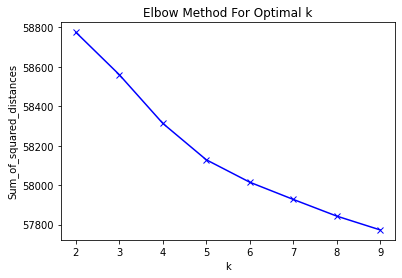

                                                    data  cluster
46309   Memorial Day: Have read many of Vince Flynn's...        0
11882   Horrible: I am a huge Catherine Coulter fan a...        0
11883   do not understand this one: The book has neve...        0
25260   Everything the short books lack: This book is...        0
50023   NOT WHAT I THOUGHT IT WAS: when I ordered the...        0
...                                                  ...      ...
48589   drags: Not very good. The movie has good char...        2
13596   Organic farming for the open minded: This was...        2
13602   DON'T WASTE YOUR MONEY: Horrible movie. I act...        2
48794   terrific fun ... even for someone who cringes...        2
0       Best Movie I've Seen in Years!: Okay, it was ...        2

[60000 rows x 2 columns]


In [ ]:
Sum_of_squared_distances = []
K = range(2,10)
for k in tqdm.tqdm(K):
   km = KMeans(n_clusters=k, max_iter=200, n_init=10)
   km = km.fit(sub_tfidf)
   Sum_of_squared_distances.append(km.inertia_)
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

true_k = 3
model = KMeans(n_clusters=true_k, init='k-means++', max_iter=200, n_init=10)
model.fit(sub_tfidf)
labels=model.labels_
review_cl=pd.DataFrame(list(zip(df["data"],labels)),columns=['data','cluster'])
print(review_cl.sort_values(by=['cluster']))

Thanks to the Elbow method, we found that 5 clusters is the optimal number of clusters. But we decided to fit our model by taking 5 clusters into consideration because next results will be better assuming this hypthesis.

Then we use WordCloud representation to vizualize our clusters.


  0%|          | 0/3 [00:00<?, ?it/s]

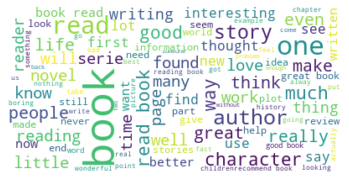


 33%|███▎      | 1/3 [00:05<00:10,  5.25s/it]

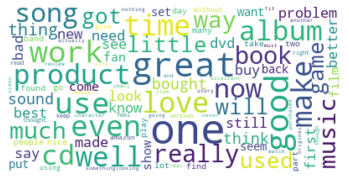


 67%|██████▋   | 2/3 [00:21<00:11, 11.60s/it]

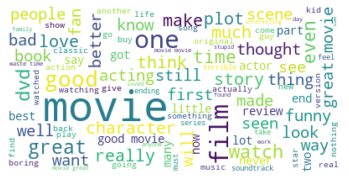


100%|██████████| 3/3 [00:23<00:00,  7.69s/it]


In [ ]:
from wordcloud import WordCloud
result={'cluster':labels,'review':df['data']}
result=pd.DataFrame(result)
for k in tqdm.tqdm(range(0,true_k)):
   s=result[result.cluster==k]
   text=s['review'].str.cat(sep=' ')
   text=text.lower()
   text=' '.join([word for word in text.split()])
   wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(text)

   titles=review_cl[review_cl.cluster==k]['data']         
   plt.figure()
   plt.imshow(wordcloud, interpolation="bilinear")
   plt.axis("off")
   plt.show()

NB : Here we can notice that our 3 wordcloud are revelants (they represent book reviews, song review and movie review). If we have made 4 or 5 clusters we could have also have a video games cluster (but also some irrevelant clusters).

In [ ]:
import umap
import hdbscan

In [ ]:
umap_reducer = umap.UMAP(random_state=42, n_components=2)
embeddings = umap_reducer.fit_transform(df_w2v_tfidf)

/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


We have also use hdbscan to cluster our data (The algorith is better than K-means to find high density clusters)

In [ ]:
clusterer = hdbscan.HDBSCAN(min_cluster_size=15, min_samples=5)
clusterer.fit(embeddings)
df['cluster'] = clusterer.labels_

In [ ]:
import altair as alt

In [ ]:
df_plot = pd.DataFrame(embeddings, columns=['x','y'])

In [ ]:
df_plot['cluster'] = clusterer.labels_
df_plot['data'] = df['data']

In [ ]:
sub_plot = df_plot.sample(n=5000, random_state=1)


In [ ]:
alt.Chart(sub_plot).mark_circle(size=60).encode(
    x='x',
    y='y',
    color=alt.Color('cluster', scale=alt.Scale(scheme='category20')),
    tooltip=['data', 'cluster']
).properties(
    width=800,
    height=600
).interactive()

alt.Chart(...)

There is 3 major output clusters. The pink one correspond to song reviews, the orange one to video games and the grey one contains movies, books and others reviews mixed. Maybe this problem come to the fact that our dataset is a too little sample of the total database (and to the limitation of altair which cannot plot more than 5000 points).

In [ ]:
# We try to use an other tfidf transformation that include a Spacy part before embeddings

def get_tfidf_vector(word2vec_model, query):

    query = nlp(query, disable=["tagger", "parser", "ner"])
    query = [token.lemma_.lower() for token in query 
         if token.is_alpha 
         and not token.is_stop 
         and not token.is_punct]
    if len(query) >= 1:
      words = tfidf.transform([query])
      return words @ word2vec_model.wv.vectors
    else:
        return []

It allow us to get reviews similar to a given query (here a simple word) based on cosine similarity

In [ ]:
query = get_tfidf_vector(w2v_model, 'computer')
sims = cosine_similarity(query.reshape(1,300), df_w2v_tfidf)
ix = np.flip(np.argsort(sims)).tolist()[0][:10]
df['data'][ix]

21627     Lousy Program: I used this program to transfe...
55733     Does not support Windows XP: Does not support...
18239     DOES NOT WORK WITH WINDOWS XP: This game does...
18786     Bad Performance: When I first heard of Window...
38954     DRM!: The ability of EA to arbitrarily decide...
4967      DONT BUY THIS COMPUTER!!: THIS IS THE WORST C...
46878     missing something: The game you sent does not...
4825      Works WITH OUT Problems: This computer is gre...
47220     USB to Serial - Garmin Compatible: I installe...
17746     so so: The installation was fine but when I w...
Name: data, dtype: object

We use Annoy to approximate nearest neighbor matching

In [ ]:
from annoy import AnnoyIndex
# search tree 
t = AnnoyIndex(df_w2v_tfidf.shape[1], 'angular') 

In [ ]:
# add all our vectors to the tree
for i in tqdm.tqdm(range(df_w2v_tfidf.shape[0]),position=0, leave=True):
    t.add_item(i, df_w2v_tfidf[i])

100%|██████████| 60000/60000 [00:06<00:00, 9178.83it/s]


In [ ]:
# build the search tree (clustering)
# thereafter search will be performed within the nearest partitions 
t.build(50, n_jobs=-1)

True

In [ ]:
t.get_nns_by_vector(df_w2v_tfidf[0], n=10, include_distances=True)

([0, 100, 7611, 1644, 56545, 38283, 34537, 33928, 11247, 47876],
 [0.0,
  0.3227992057800293,
  0.32406118512153625,
  0.351162314414978,
  0.3524942696094513,
  0.35402733087539673,
  0.36200639605522156,
  0.3669271767139435,
  0.3713657557964325,
  0.3734703063964844])

In [ ]:
# we can search by review index
knn_search = t.get_nns_by_item(0, n=10, include_distances=True) ## for first review
df['data'][knn_search[0]] 

0         Best Movie I've Seen in Years!: Okay, it was ...
100       Terrifac!: I am so glad to see they have brou...
7611      Undercover Excellence: I have rented this mov...
1644      Kids liked it....: I thought it was terrible....
56545     WHAT A LOAD OF [...]: Gawd! This movie really...
38283     Not a very young kid friendly movie: My 6 yea...
34537     BEST MOVIE: This is one of my favorite movies...
33928     WHAT WAS I THINKING??: For years I've waited ...
11247     Awful! This is NOT THE CARTOON YOU REMEMBER!:...
47876     Great!: I would recommend this product to Chi...
Name: data, dtype: object

As first review is a movie review, it works well ! 

In [ ]:
# search with a free query
query = get_tfidf_vector(w2v_model, 'video game')

knn_search = t.get_nns_by_vector(query[0], n=10, include_distances=True) 

df['data'][knn_search[0]]

38580     awesomeist game ever: this game was awesome i...
1400      A Fighter and RPG in one!: A great game for t...
27789     A Cool Game: This game is loads of fun, i rea...
51201     A Batolicous Game,: Batman returns, rock. Thi...
914       Rockstar Games: If you have never played this...
59522     More of the same: This game should have been ...
21006     One,Two,Three, World Series Baseball 2K1 has ...
6123      best game I've played for awhile: It has prob...
13208     It's worth the money...: The game is a lot of...
40468     Dinosaurs are awesome in games.: I remember r...
Name: data, dtype: object

We get video games reviews.

We got quite cool results, but we are sugest to the limit of our dataset (we don't have the name of the Amazon articles) We also try to make predictions (see second notebook).